# Basic python imports and model settings

In [4]:
import underworld.visualisation as vis

from underworld import function as fn
import underworld as uw

import matplotlib.pyplot as pyplot
import numpy as np
from scipy.spatial import distance

import math
import os

import time as ti

# uw.matplotlib_inline()

# details of the bottom curve
L = [160, 80, 40, 20, 10, 5] # values in Experiment D AND in Experiment B
i = 2
maxX = L[i] * 1000.
omega = 2.0 * np.pi / maxX
average_bedthickness = 2500.
surface_height = average_bedthickness
maxY = surface_height #+ 250.     # free air = maxY - surface_height (defined above)

beta = fn.misc.constant(1.)
beta = 1000. + 1000. * fn.math.sin(omega * fn.input()[0])

A = 1e-16	# I think, this is already per anno..
n = 3.

annual_snowfall = 0.5 # in m

resY = 40
resX = 250

print("resX: " + str(resX) + " resY: " + str(resY))

# generate output path
outputPath = os.path.join(os.path.abspath("."), "output/")
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

# generate output file
outputFile = os.path.join(os.path.abspath("."), "output.txt")
if os.path.exists(outputFile):
    os.rename(outputFile, outputFile + ".bkp")

delta_timestep = 1.						# in years, used in the main loop
# after how many timesteps do we need new figures?
update_figures_after_n_timesteps = 1
number_of_deformation_lines = 11

number_of_deformation_points = 50000
distance_between_deformation_lines = maxY / (number_of_deformation_lines + 1)

resX: 250 resY: 40


# Mesh + mesh variables

In [5]:
elementType = "Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian(elementType=(elementType),
                                elementRes=(resX, resY),
                                minCoord=(0., 0.),
                                maxCoord=(maxX, maxY),
                                periodic=[False, False])

submesh = mesh.subMesh

# save the mesh
# mesh.save(outputPath + "mesh.h5")

velocityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=mesh.dim)
pressureField = uw.mesh.MeshVariable(mesh=mesh.subMesh, nodeDofCount=1)

viscosityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

rockIceInterface = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)
rockIceInterface.data[:] = False

strainRateField = mesh.add_variable(nodeDofCount=1)
tractionField = mesh.add_variable(nodeDofCount=2)

tractionField.data[:] = 0.
pressureField.data[:] = 0.
velocityField.data[:] = [0., 0.]

# Swarm

In [6]:
part_per_cell = 50
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm=swarm, particlesPerCell=part_per_cell)
swarm.populate_using_layout(layout=swarmLayout)

surfaceSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
deformationSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

# create pop control object
pop_control1 = uw.swarm.PopulationControl(swarm, aggressive=True, particlesPerCell=part_per_cell)
pop_control2 = uw.swarm.PopulationControl(surfaceSwarm)
pop_control3 = uw.swarm.PopulationControl(deformationSwarm)

# ### Create a particle advection system
#
# Note that we need to set up one advector systems for each particle swarm (our global swarm and a separate one if we add passive tracers).

advector1 = uw.systems.SwarmAdvector(swarm=swarm,            velocityField=velocityField, order=2)
advector2 = uw.systems.SwarmAdvector(swarm=surfaceSwarm,     velocityField=velocityField, order=2)
advector3 = uw.systems.SwarmAdvector(swarm=deformationSwarm, velocityField=velocityField, order=2)

# Tracking different materials

materialVariable = swarm.add_variable(dataType="int", count=1)
director = swarm.add_variable(dataType="double", count=2)

# passive markers at the surface are inserted whenever 100 m of new snow hav been created in the main loop
deformationPoints = np.array(np.meshgrid(np.linspace(0., maxX, int(
    number_of_deformation_points)), np.linspace(0., maxY, number_of_deformation_lines))).T.reshape(-1, 2)
deformationSwarm.add_particles_with_coordinates(deformationPoints)

surfacePoints = np.zeros((int(number_of_deformation_points), 2))
surfacePoints[:, 0] = np.linspace(
    0., maxX, int(number_of_deformation_points))
surfacePoints[:, 1] = surface_height
surfaceSwarm.add_particles_with_coordinates(surfacePoints)

particleDensity = swarm.add_variable(dataType="double", count=1)
particleDensity.data[:] = 0.0

# Initialise the 'materialVariable' data to represent different materials.
materialA = 0  	# accommodation layer, a.k.a. Sticky Air
materialV = 1  	# ice, isotropic
materialR = 2   # rock

coord = fn.input()

conditions = [(coord[1] > surface_height, materialA),
              (True, materialV)]

materialVariable.data[:] = fn.branching.conditional(conditions).evaluate(swarm)
director.data[:] = [0., 1.]

k = np.random.rand(swarm.particleGlobalCount) * np.pi
director.data[:, 0] = np.cos(k)
director.data[:, 1] = np.sin(k)

iceAirInterfaceSet = []
for index, coord in enumerate(mesh.data):
    if coord[1] <= surface_height:
        iceAirInterfaceSet.append(index)
iceAirInterfaceSet = np.argsort(mesh.data[iceAirInterfaceSet, 1])[-resX:-1]
iceAirInterfaceSet = np.argsort(iceAirInterfaceSet, 0)

# Functions

In [7]:
strainRateTensor = fn.tensor.symmetric(velocityField.fn_gradient)
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateTensor)

minViscosityIceFn = fn.misc.constant(1e+5 / 3.1536e7)
maxViscosityIceFn = fn.misc.constant(1e+15 / 3.1536e7)

viscosityFnAir = fn.misc.constant(1e6)
viscosityFnRock = fn.misc.constant(1e17)
viscosityFnIceBase = 0.5 * A ** (-1./n) * (strainRate_2ndInvariantFn)**((1.-n) / n)
viscosityFnIce = fn.misc.max(fn.misc.min(viscosityFnIceBase, maxViscosityIceFn), minViscosityIceFn)
viscosityFnIce2 = 0.9 * viscosityFnIce # anisotropic ice: basal plane viscosity

viscosityMap = {
                materialV: viscosityFnIce,
                materialA: viscosityFnAir,
                materialR: viscosityFnRock
               }

viscosityMap2 = {
                materialV: viscosityFnIce2,
                materialA: viscosityFnAir,
                materialR: viscosityFnRock
                }

viscosityFn = fn.branching.map(fn_key=materialVariable, mapping=viscosityMap)
viscosityFn2 = fn.branching.map(fn_key=materialVariable, mapping=viscosityMap2)

logViscosityFn = fn.math.log10(fn.misc.max(fn.misc.min(viscosityFnIceBase, viscosityFnRock), viscosityFnAir))

devStressFn = 2.0 * viscosityFn * strainRateTensor
shearStressFn = strainRate_2ndInvariantFn * viscosityFn * 2.0

densityFnAir = fn.misc.constant(0.)
densityFnIce = fn.misc.constant(910.)
densityFnRock = fn.misc.constant(2700.)

densityMap = {materialA: densityFnAir,
              materialV: densityFnIce,
              materialR: densityFnRock}

densityFn = fn.branching.map(fn_key=materialVariable, mapping=densityMap)

particleDensity.data[:] = densityFn.evaluate(swarm)

director_angle = fn.math.abs(fn.math.asin(director[1]))

surf_inclination = 0.0 * np.pi / 180. # 0.1 = Experiment D, 0.5 = Experiment B
z_hat = (math.sin(surf_inclination), - math.cos(surf_inclination))
buoyancyFn = densityFn * z_hat * 9.81

# Solver and boundary conditions

In [8]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
base = mesh.specialSets["MinJ_VertexSet"]
top = mesh.specialSets["MaxJ_VertexSet"]

velocityField.data[:] = [0., 0.]

botSet = mesh.specialSets['Bottom_VertexSet']
topSet = mesh.specialSets['Top_VertexSet']
leftSet = mesh.specialSets['Left_VertexSet']
rightSet = mesh.specialSets['Right_VertexSet']

cond_dirichlet = uw.conditions.DirichletCondition(variable=velocityField, indexSetsPerDof = 
                                                  (leftSet + rightSet + botSet, botSet + topSet))

### work on the outflow at a divide!
snowmass_per_anno = annual_snowfall * maxX # note: minX = 0.
prefac = 0.5 * snowmass_per_anno / 0.4 # 0.5 because flow goes to 2 directions: left + right

velocityField.data[:] = [0., 0.]

for i, z in zip(mesh.specialSets["MinI_VertexSet"], mesh.data[mesh.specialSets["MinI_VertexSet"], 1]):
    z = mesh.data[i, 1]
    velocityField.data[i, 0] = -0.5 * prefac * (maxY**4 - (maxY - z)**4) / maxY**5 # function of z
for i in mesh.specialSets["MaxI_VertexSet"] :
    z = mesh.data[i, 1]
    velocityField.data[i, 0] = 0.5 * prefac * (maxY**4 - (maxY - z)**4) / maxY**5 # function of z

velocityField.data[mesh.specialSets["MaxJ_VertexSet"], 1] = -annual_snowfall

stokes = uw.systems.Stokes(
    velocityField=velocityField,
    pressureField=pressureField,
    voronoi_swarm=swarm,
    conditions=[
            cond_dirichlet,
            ],
    _fn_viscosity2=viscosityFn2,
    _fn_director=director,
    fn_viscosity=viscosityFn,
    fn_bodyforce=buoyancyFn,
)

solver = uw.systems.Solver(stokes)

# solver.set_inner_method("lu")
# solver.set_inner_method("superlu")
solver.set_inner_method("mumps")

#solver.set_penalty(1.0e10)  # higher penalty = larger stability
# solver.options.scr.ksp_rtol = 1.0e-3

nl_tol = 2.e1

surfaceArea = uw.utils.Integral( fn=1.0, mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral( fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

def calibrate_pressure():

    global pressureField
    global surfaceArea
    global surfacePressureIntegral

    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate() 
    pressureField.data[:] -= p0 / area

    print (f'Calibration pressure {p0 / area}')

# test it out
try:
    #solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
    solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
    solver.print_stats()
except:
    print("Solver died early..")
    exit(0)

Calibration pressure -9033867.038202522
Calibration pressure -12549286.200213298
Calibration pressure -13118456.863876726
Calibration pressure -13299879.677383957
Calibration pressure -13369093.431859765

 
Pressure iterations:  18
Velocity iterations:   1 (presolve)      
Velocity iterations:  18 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  20 (total solve)   
 
SCR RHS  setup time: 1.6160e-01
SCR RHS  solve time: 9.6495e-03
Pressure setup time: 4.5800e-04
Pressure solve time: 1.7355e-01
Velocity setup time: 7.1526e-07 (backsolve)
Velocity solve time: 9.2380e-03 (backsolve)
Total solve time   : 3.5553e-01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 



# Figures


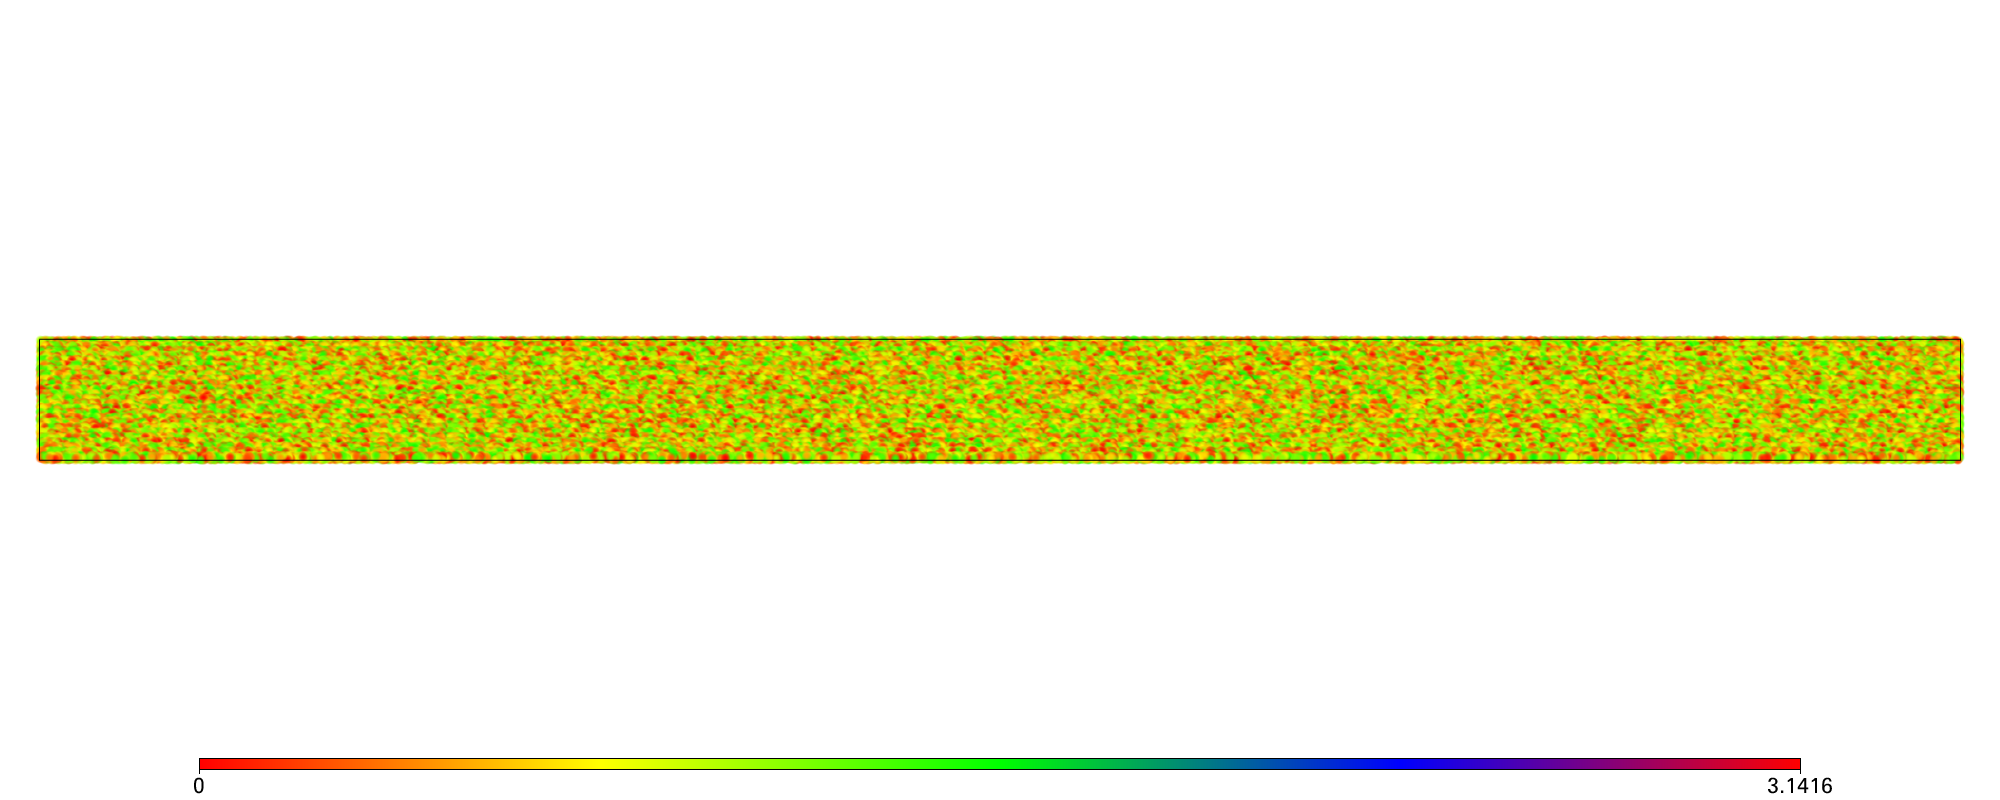


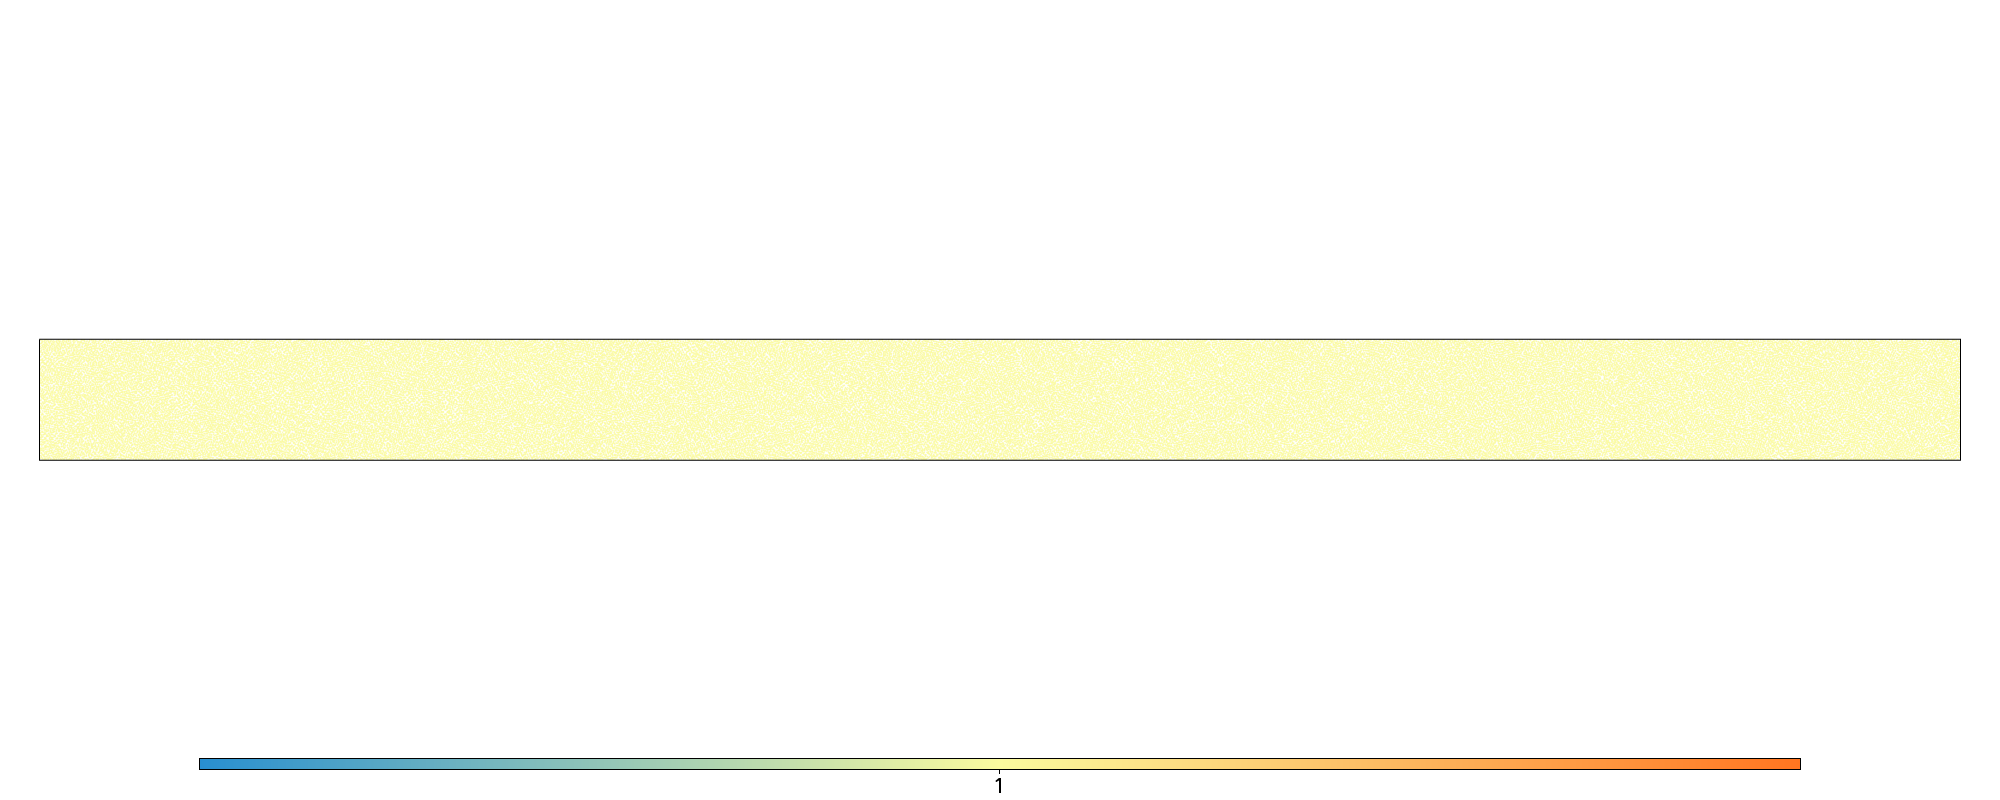


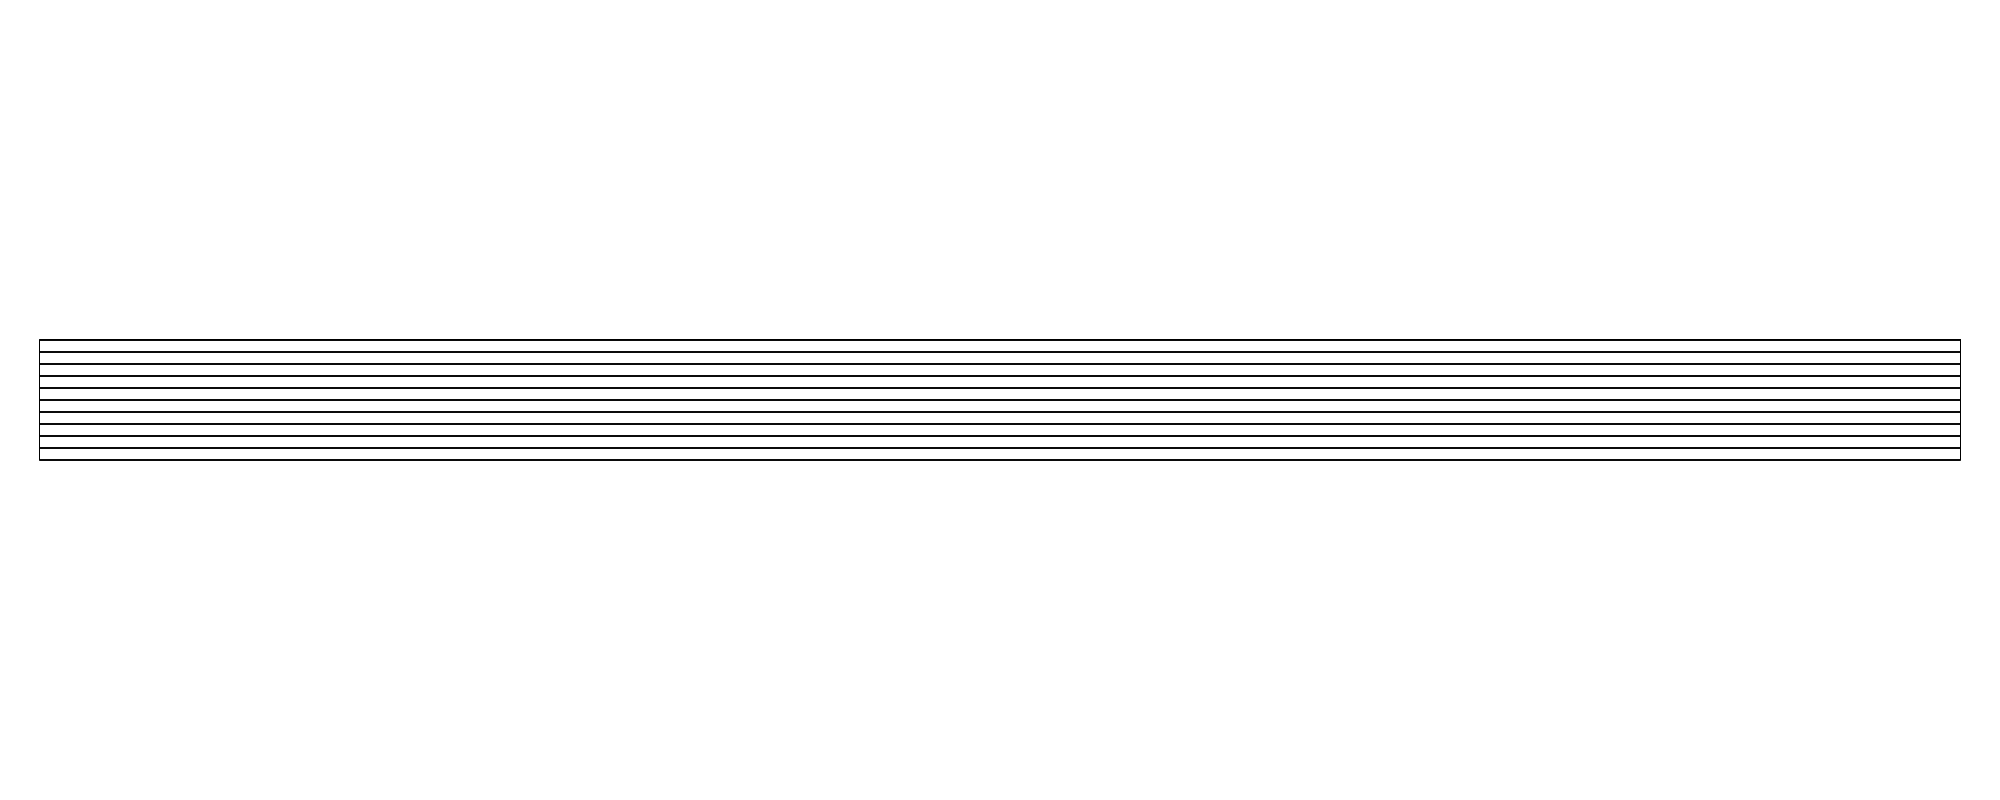


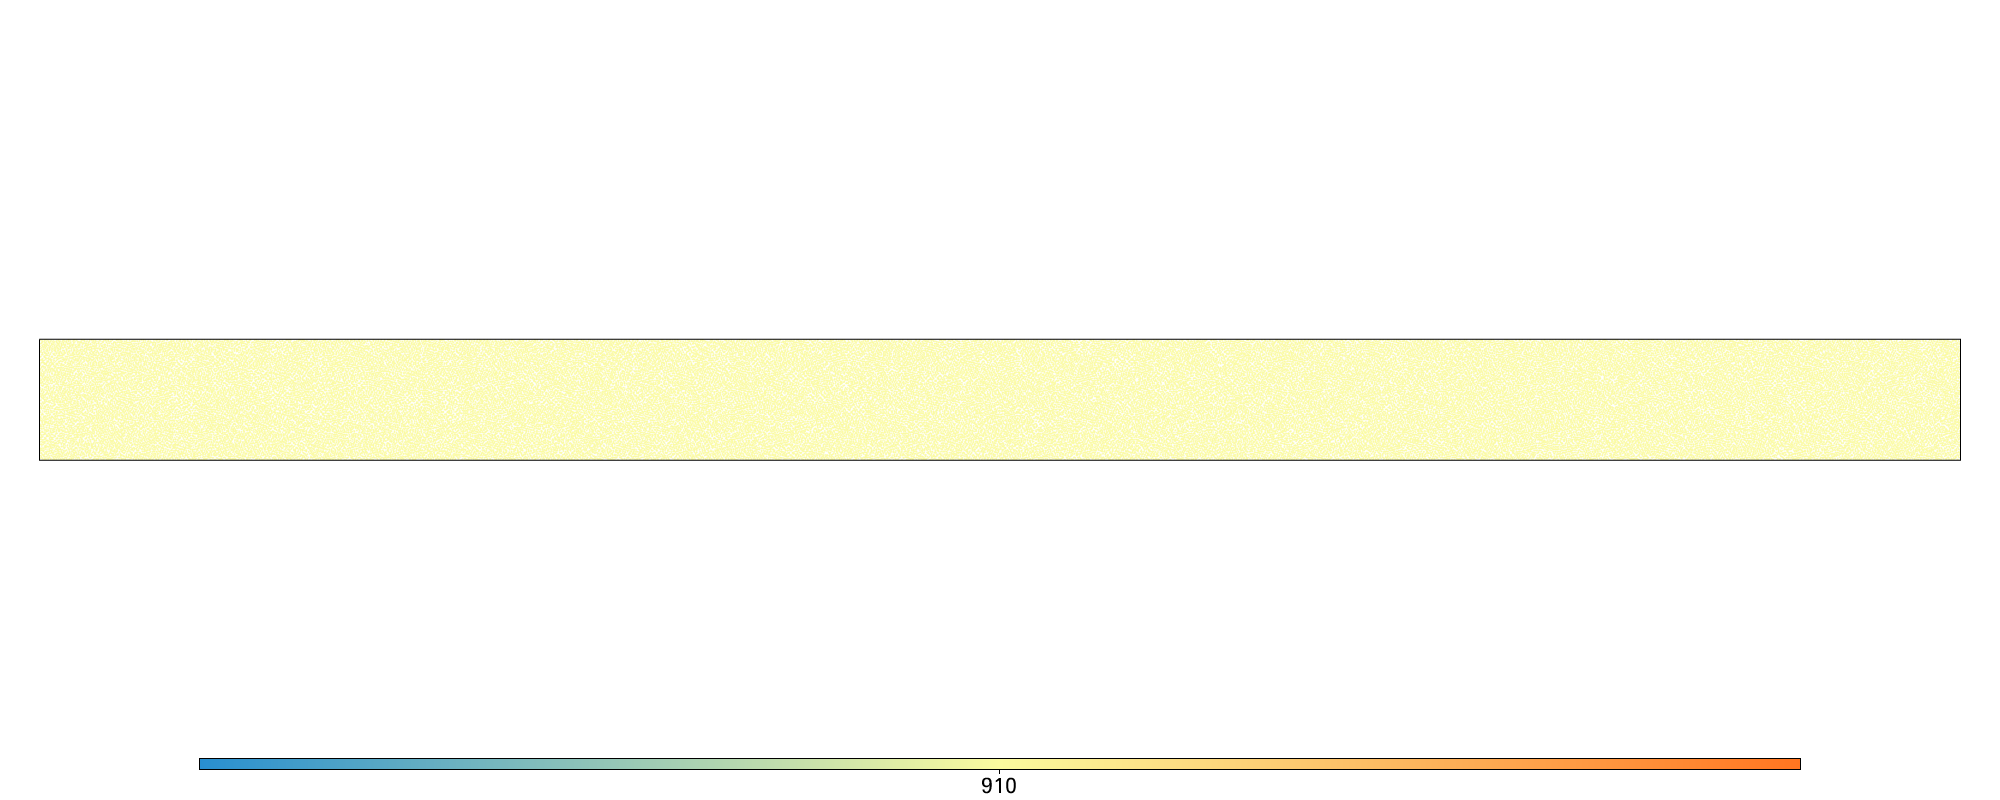


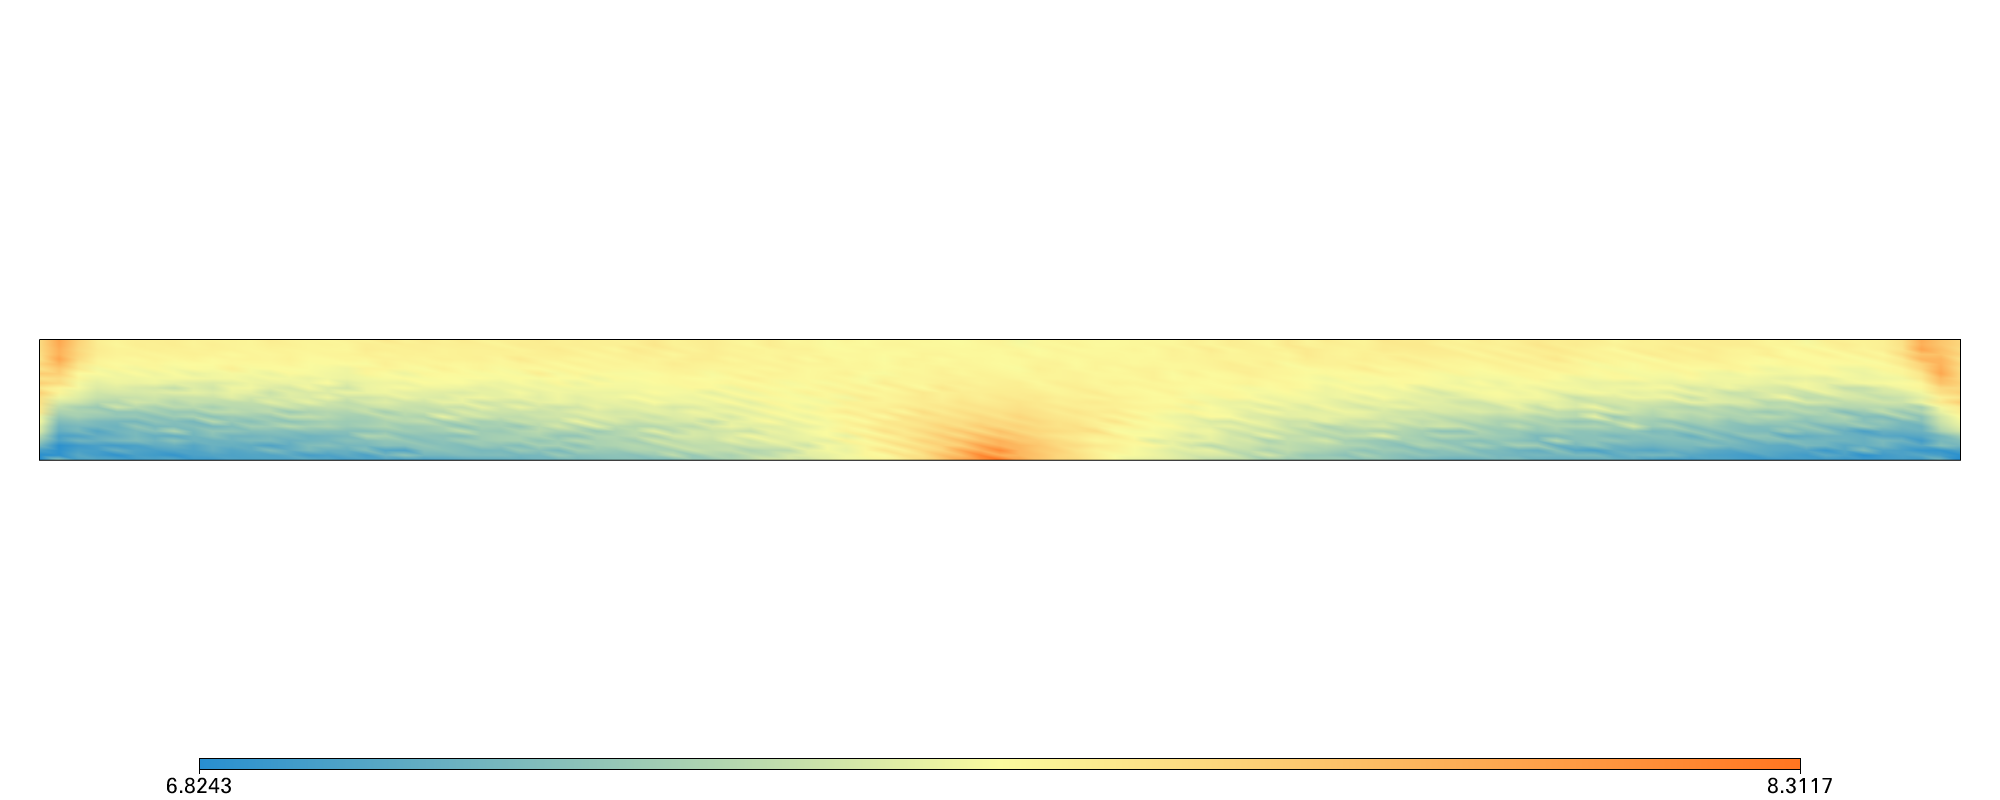


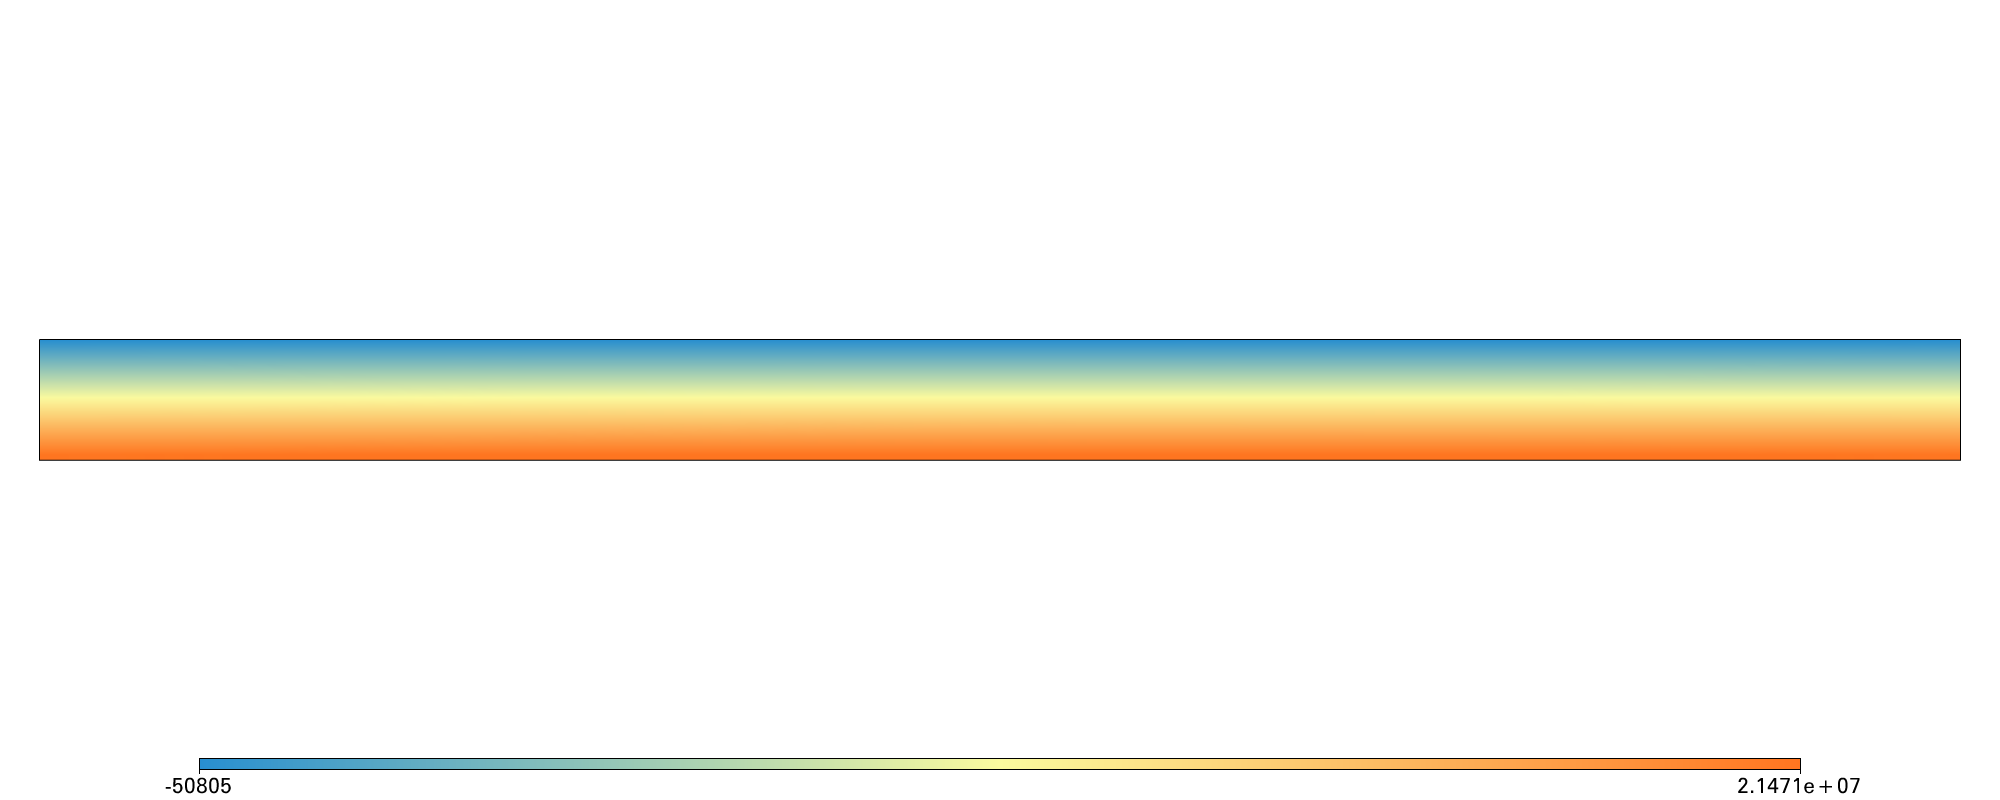


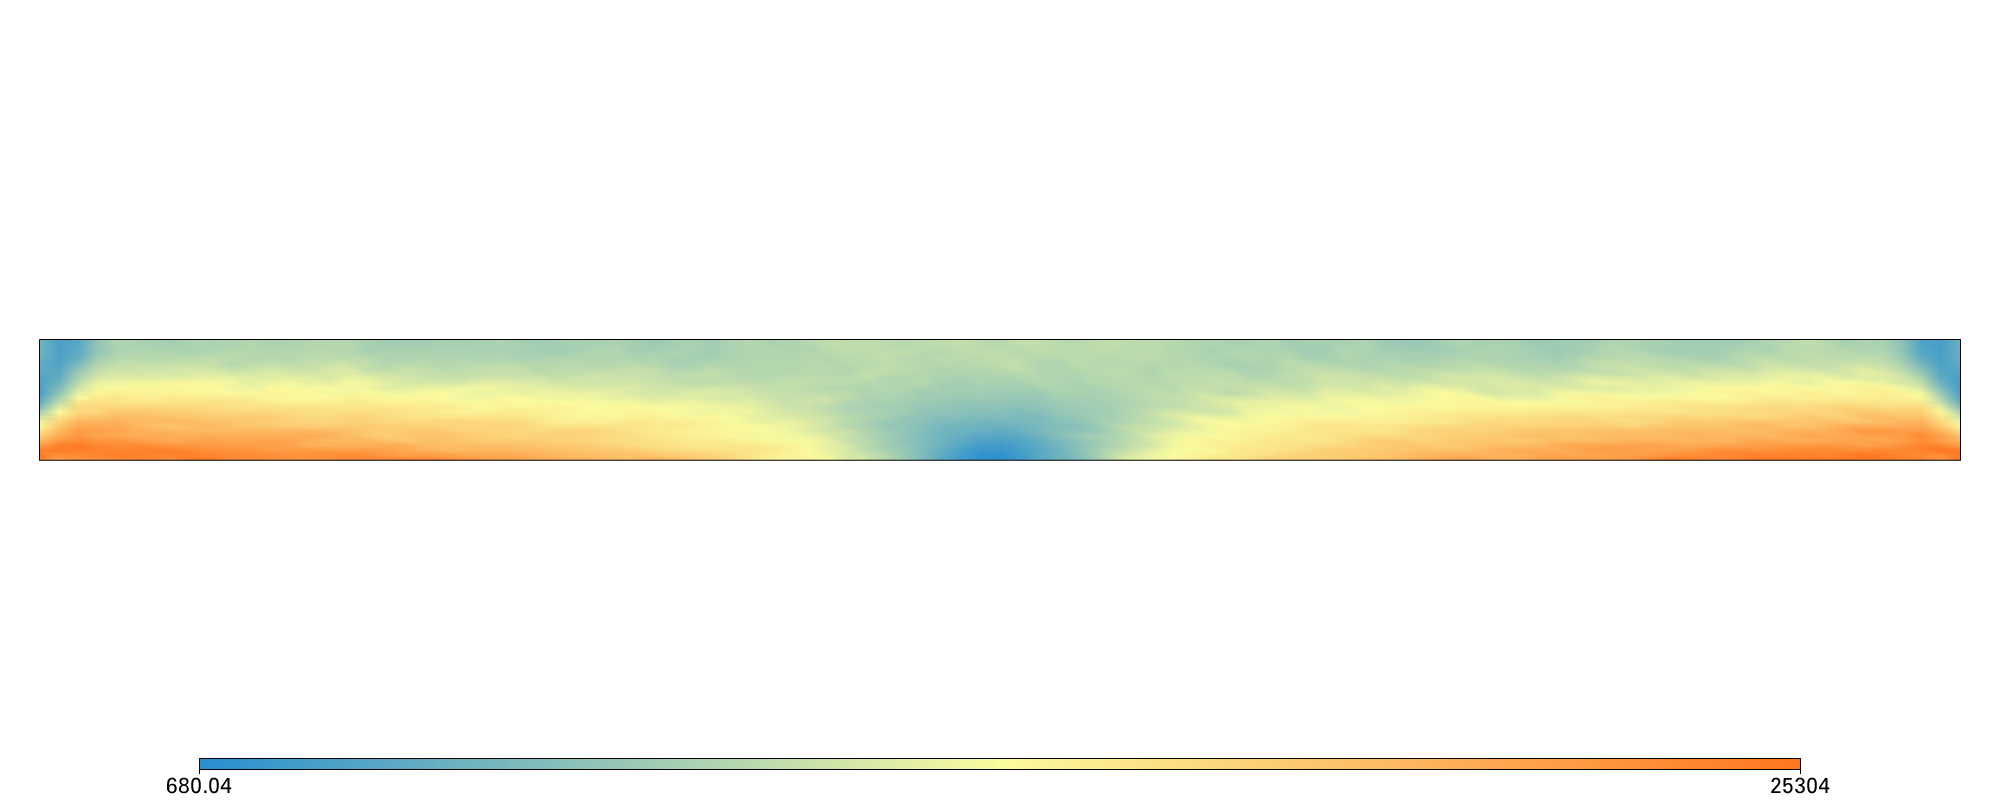


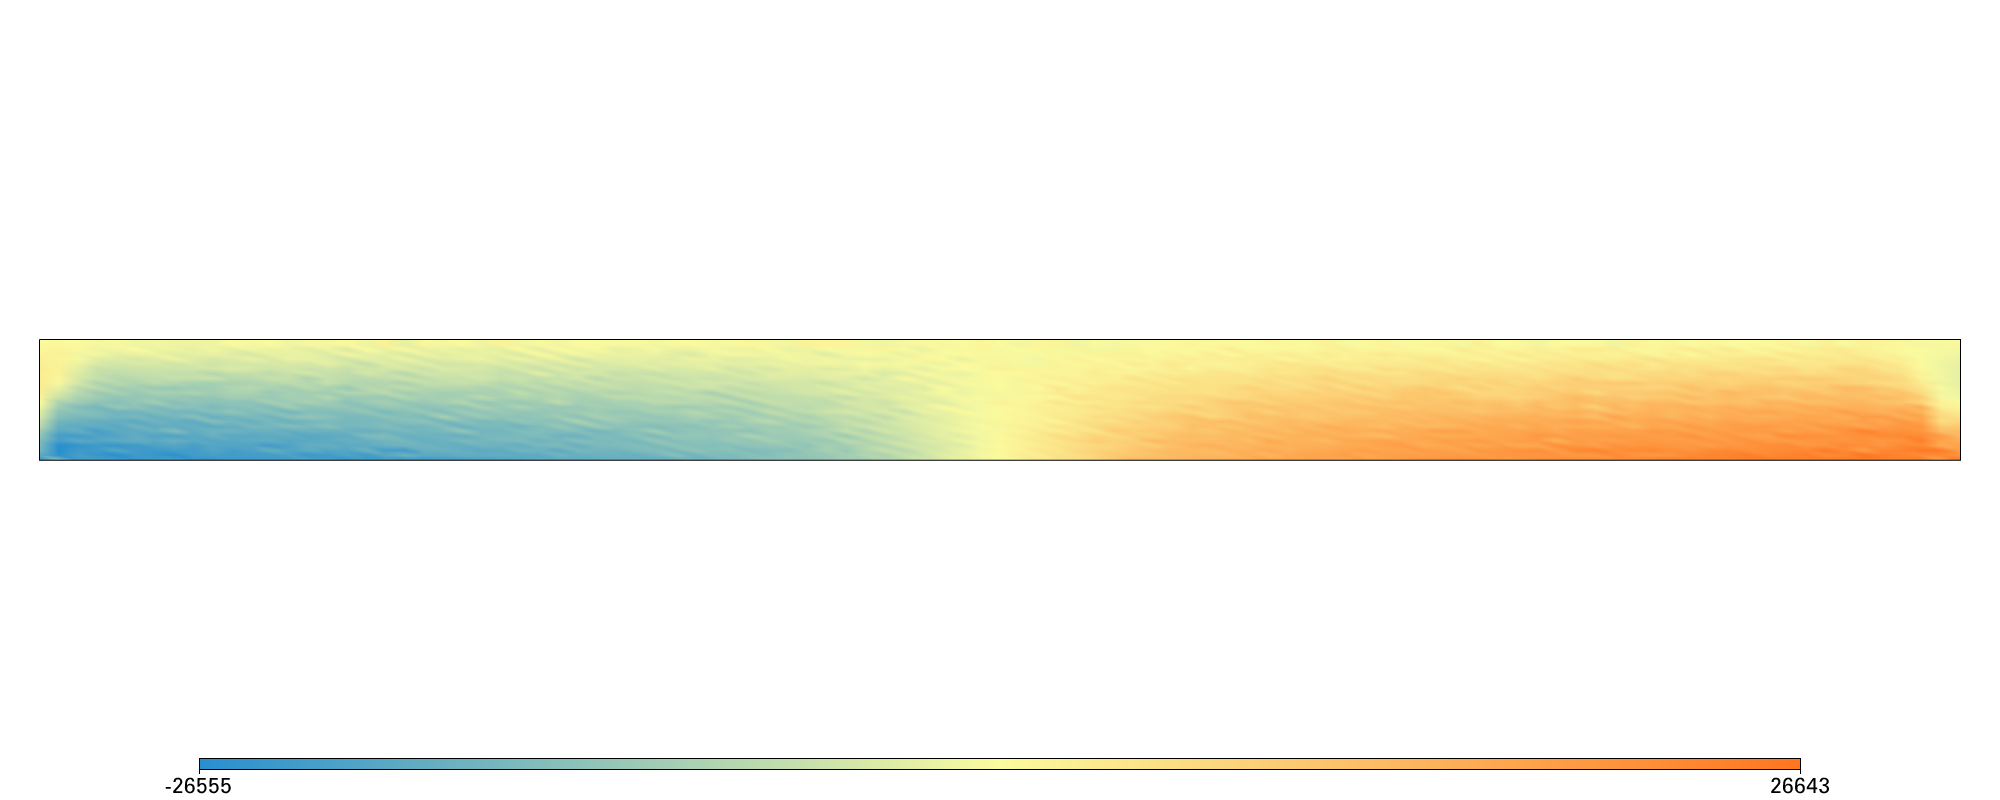


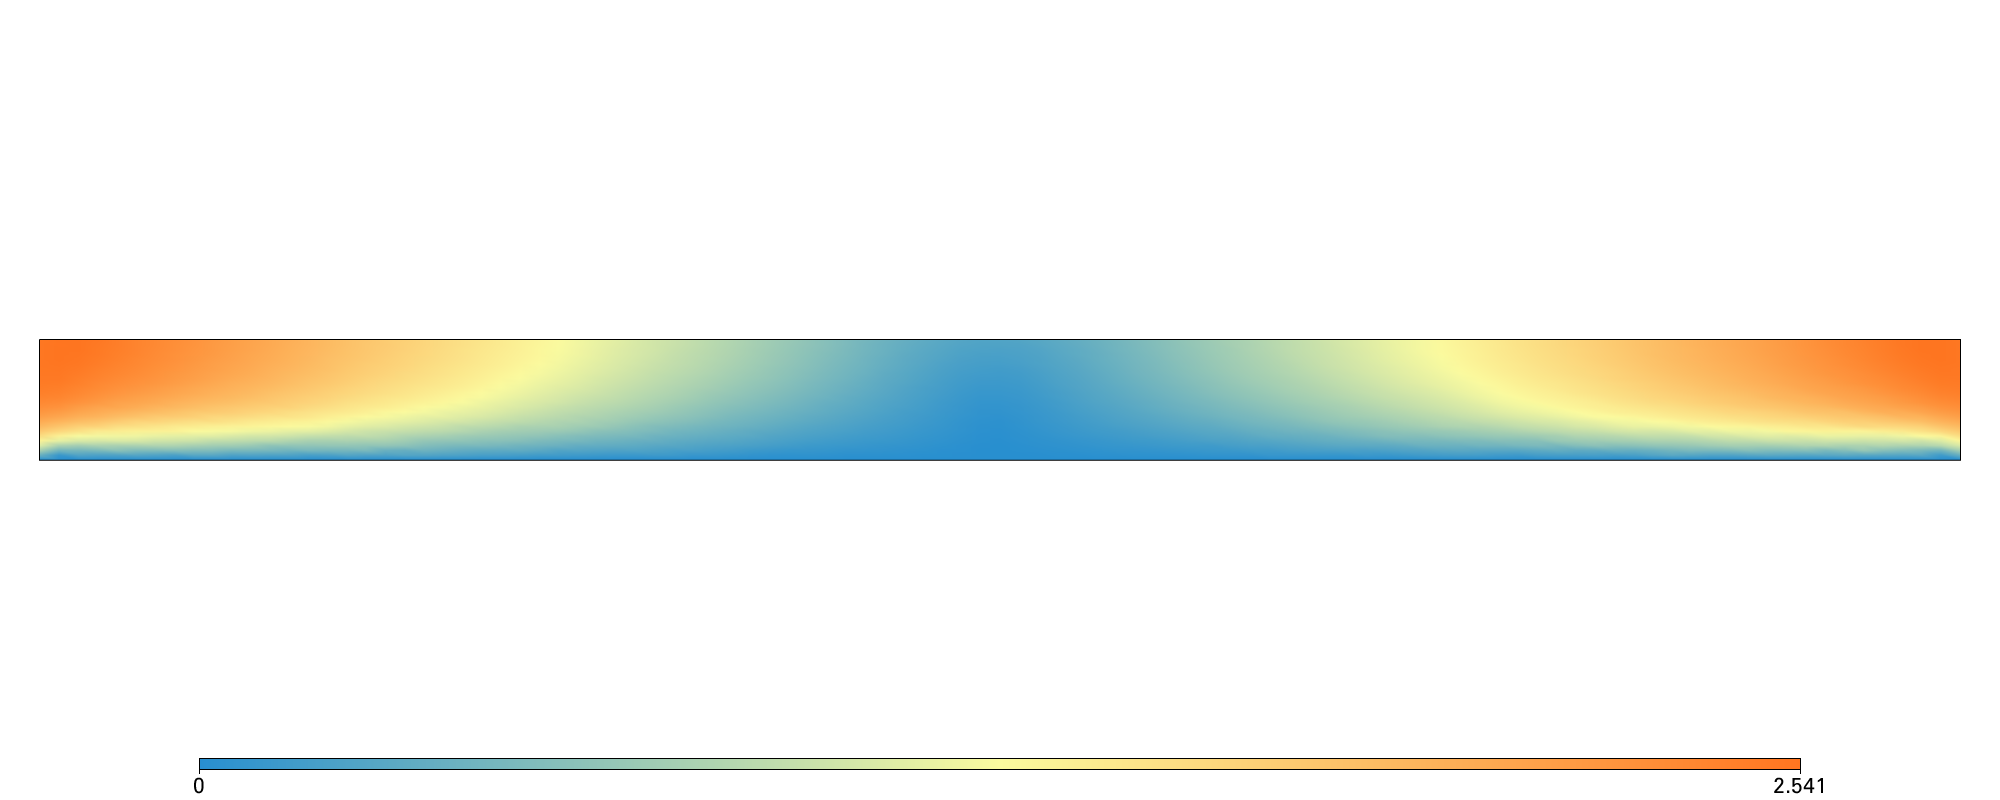


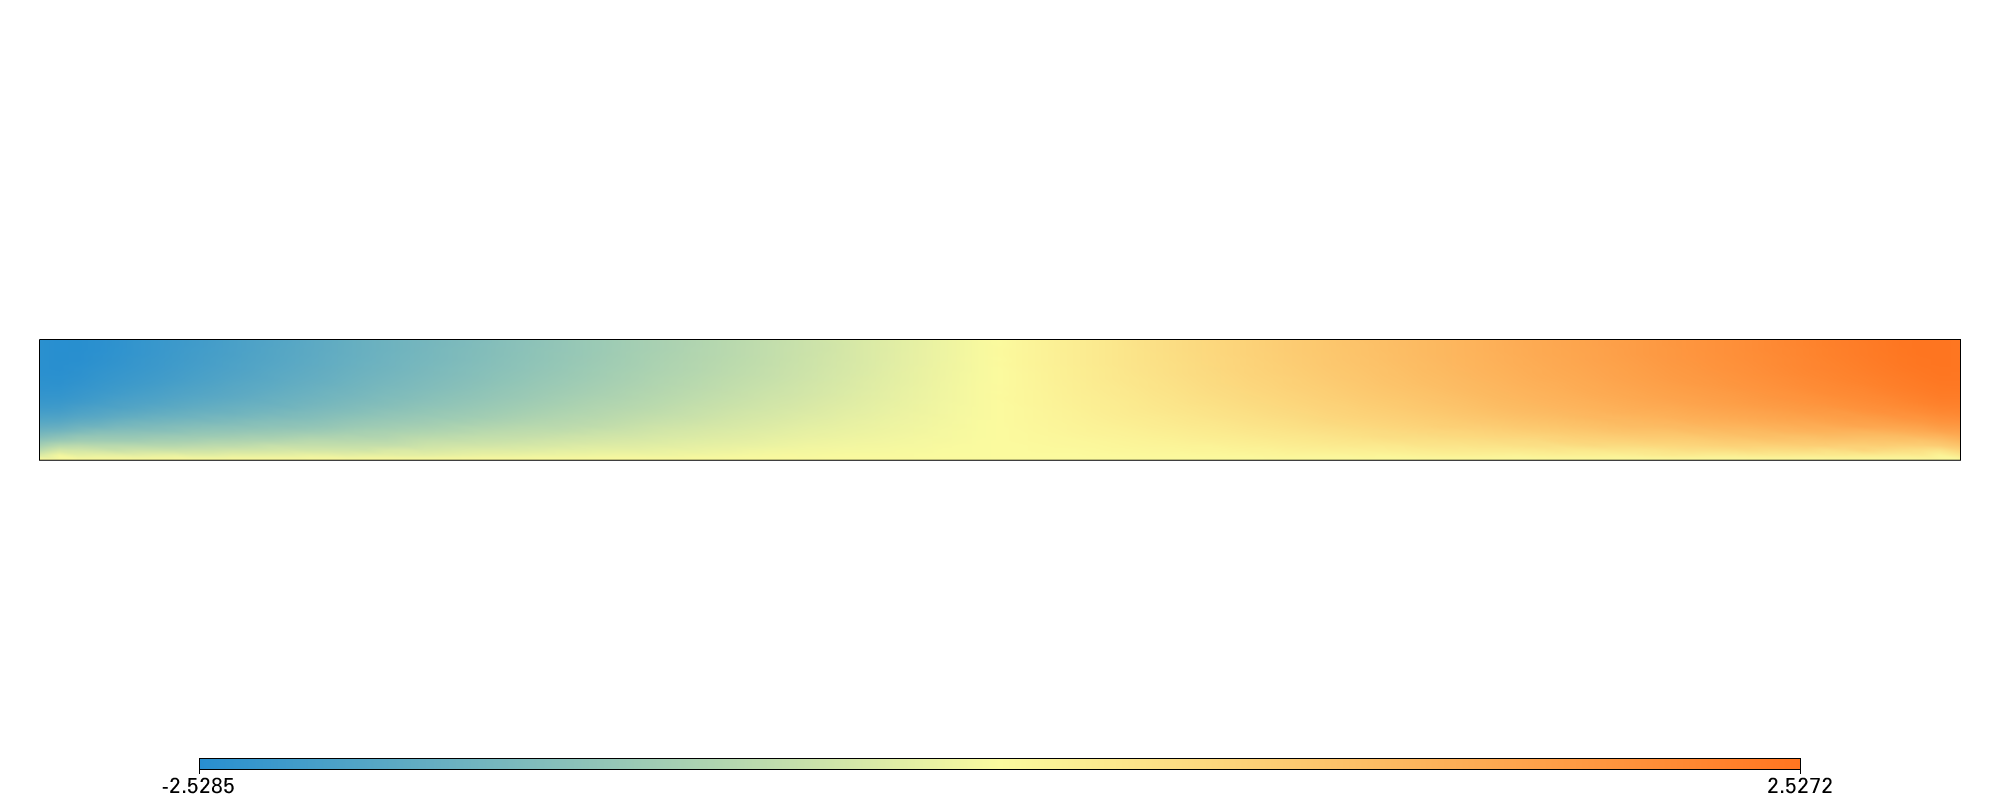


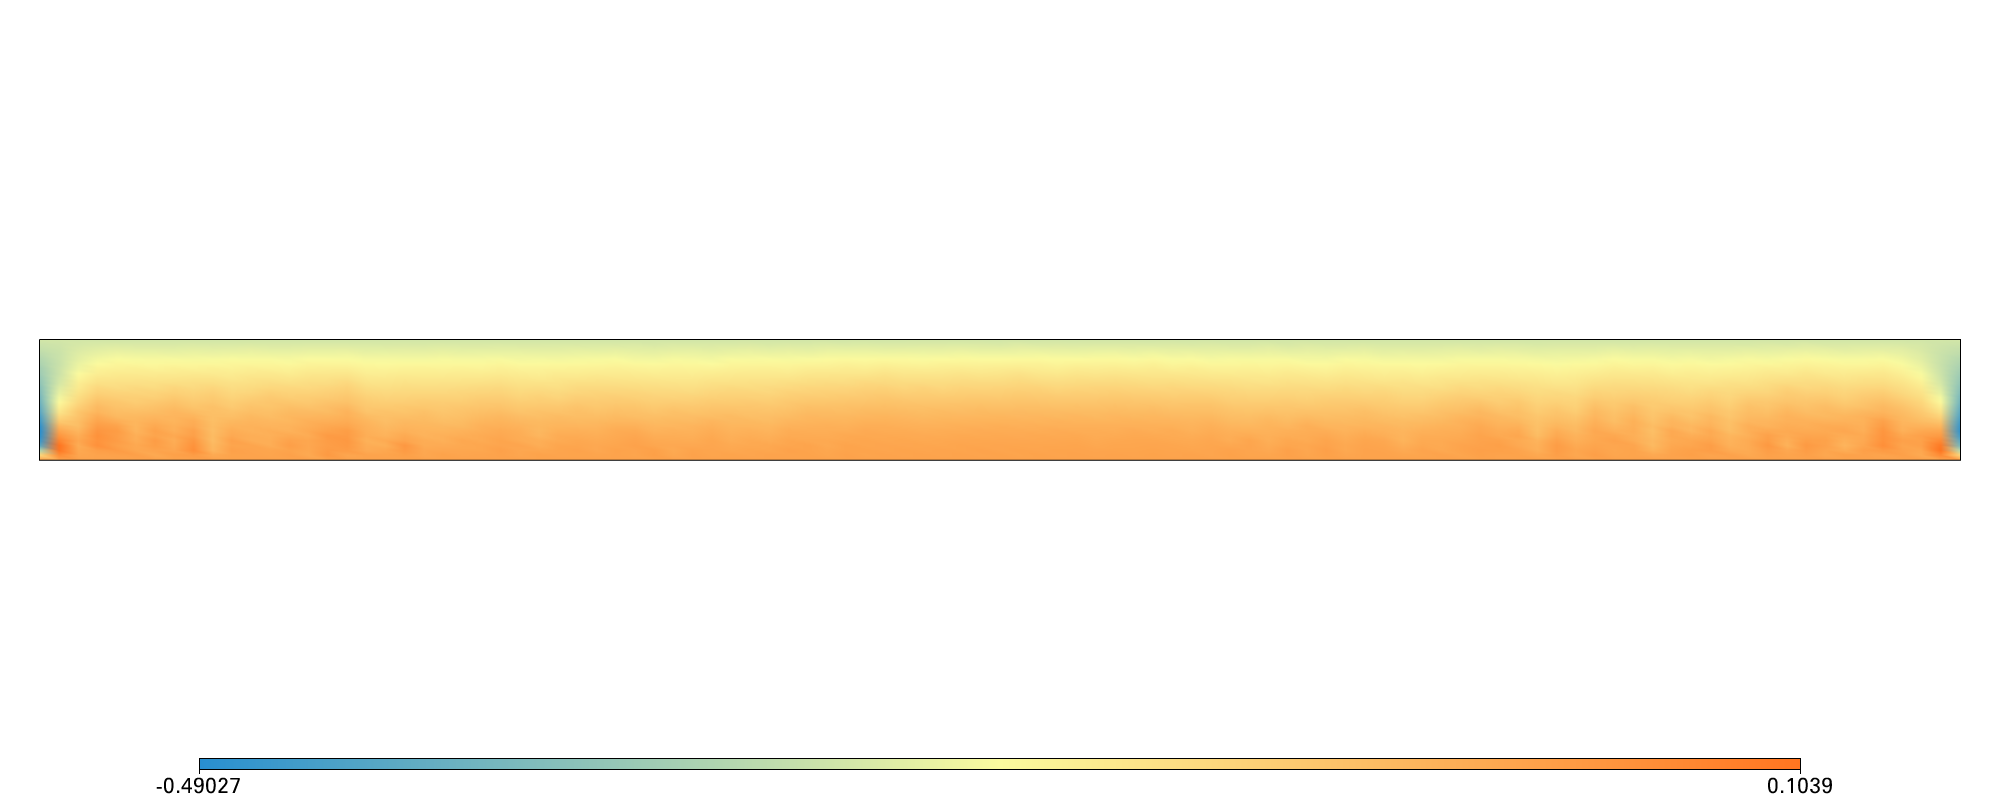

In [10]:
figDirector = vis.Figure( figsize=(2500, 500) )
#figDirector.append( vis.objects.Points( swarm, director_angle, pointSize=3.0, colours="red yellow green blue red yellow green blue red") )
figDirector.append( vis.objects.Points( swarm, director_angle, pointSize=1.0, colours="red yellow green blue red", valueRange=[0., np.pi], fn_mask=materialVariable) )
figDirector.show()
#figDirector.save_image( "director.png" )

#meshDirector = mesh.add_variable( 1 )
#projectorDirector = uw.utils.MeshVariable_Projection( meshDirector, director_angle )
#projectorDirector.solve()
#figProjectorDirector = vis.Figure(figsize=(1800, 1000))
#figProjectorDirector.append( vis.objects.Surface(mesh, projectorDirector ) )
#figProjectorDirector.show()
#figProjectorDirector.save_image("meshDirector.png")

figMaterial = vis.Figure( figsize=(2000, 800) )
figMaterial.append( vis.objects.Points( swarm, materialVariable, pointSize=2.0, fn_mask=materialVariable ) )
figMaterial.show()
#figMaterial.save_image( "material.png" )

figIsoChrones = vis.Figure(figsize=(2000, 800))
figIsoChrones.append( vis.objects.Points( deformationSwarm, pointSize=2.0) )
figIsoChrones.show()
#figIsoChrones.save_image( "isochrones.png" )

figDensity = vis.Figure(figsize=(2000, 800))
figDensity.append( vis.objects.Points( swarm, fn_mask=materialVariable, fn_colour=particleDensity, pointSize=2.0) )
figDensity.show()
#figDensity.save_image( "density.png" )

figViscosity = vis.Figure(figsize=(2000, 800))
figViscosity.append( vis.objects.Surface(mesh, logViscosityFn, ) )
figViscosity.show()
#figViscosity.save_image( "logviscosity.png" )

figPressure = vis.Figure(figsize=(2000, 800))
figPressure.append(vis.objects.Surface(mesh, pressureField ))
figPressure.show()
#figPressure.save_image( "pressure.png" )

meshDevStress = mesh.add_variable( 1 )
projectorStress = uw.utils.MeshVariable_Projection( meshDevStress, fn.tensor.second_invariant(devStressFn), type=0 )
projectorStress.solve()
figMeshStress = vis.Figure(figsize=(2000, 800))
figMeshStress.append( vis.objects.Surface(mesh, meshDevStress ) )
figMeshStress.show()
#figMeshStress.save_image("meshStress.png")

figHorShearStress = vis.Figure(figsize=(2000, 800))
figHorShearStress.append(vis.objects.Surface(mesh, devStressFn[2]))
figHorShearStress.show()
#figHorShearStress.save_image( "horShearStress.png" )

figVelocity = vis.Figure(figsize=(2000, 800))
figVelocity.append(vis.objects.Surface(mesh, fn.math.sqrt(fn.math.dot(velocityField, velocityField))))
figVelocity.show()

figXVelocity = vis.Figure(figsize=(2000, 800))
figXVelocity.append(vis.objects.Surface(mesh, velocityField[0]))
figXVelocity.show()

figYVelocity = vis.Figure(figsize=(2000, 800))
figYVelocity.append(vis.objects.Surface(mesh, velocityField[1]))
figYVelocity.show()

In [ ]:
upper_border = maxY - maxY / resY

particle_list = np.where(swarm.data[:,1] > upper_border)

num = particle_list[0].shape[0]

k = np.random.rand(num) * np.pi

director.data[particle_list, 0] = np.cos(k)
director.data[particle_list, 1] = np.sin(k)

In [ ]:
particle_list[0].shape[0]

# Tests

# Functions

In [11]:
# The stress is only guaranteed to be accurate when integrated across an element. Fluctuations
# within an element can be significant. Mapping to the mesh can help

import pdb;

def update_advection_diffusion(t):

    global meshV, maxX, maxY, snowfall_rate, nl_tol
    global calibrate_pressure

    tin = t

    while t > 0.:
    
        #solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
        solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
        
        # Retrieve the maximum possible timestep for the advection system.
        dt = min([advector1.get_max_dt(), advector2.get_max_dt(), advector3.get_max_dt(), advDiff.get_max_dt()])
        
        if dt > t:
            dt = t
            t = 0.
        else:
            t = t - dt
            
        advDiff.integrate(dt)
        # Advect using this timestep size.
        advector1.integrate(dt) # the swarm
        #advector2.integrate(dt)# the surface swarm
        advector3.integrate(dt) # the deformation swarm

        
        # particle population control
        # not sure, if this is really necessary. it is _not_ in the standard advecton code, but only if there is a mesh-deformation involved. my hope would be that this command will not allow underresolved cells
        pop_control1.repopulate()
        #pop_control2.repopulate()
        #pop_control3.repopulate()
        
        particleTemperature.data[:] = temperatureField.evaluate(swarm)
        particleDensity.data[:] = densityFn.evaluate(swarm)
        
        c_axis_rotation(dt)

    return time+tin

def update_infinite_flow(t):
    
    """
    In order for infinite flow to work you need to
    a) use the same medication as MC Escher,
    b)	1) generate 'inclination' --> z_hat definition
        2) activate wrapping by setting 'periodic = [True, False]' during the mesh creation
    """
    
    global meshV, maxX, maxY, snowfall_rate, nl_tol
    global calibrate_pressure
    
    tin = t
    
    while t:
        
        solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
        
        # Retrieve the maximum possible timestep for the advection system.
        dt = min([advector1.get_max_dt(), advector2.get_max_dt(), advector3.get_max_dt()])
        
        print(f'---------------------{dt}')
        #exit(0)
        
        if dt > t:
            dt = t
            t = 0.
        else:
            t = t - dt
            
        print (t)
        
        # Advect using this timestep size.
        advector1.integrate(dt) # the swarm
        #advector2.integrate(dt)# the surface swarm
        advector3.integrate(dt) # the deformation swarm
        
        # particle population control
        # not sure, if this is really necessary. it is _not_ in the standard advecton code, but only if there is a mesh-deformation involved. my hope would be that this command will not allow underresolved cells
        pop_control1.repopulate()
        #pop_control2.repopulate()
        #pop_control3.repopulate()
        
        c_axis_rotation(dt)

    return time+tin

def c_axis_rotation(dt):

    iceIndices = np.array(np.where(materialVariable.data == materialV)[0])
    #pdb.set_trace()
    velGrad = velocityField.fn_gradient.evaluate(  swarm ).reshape(swarm.particleGlobalCount , 2, 2)
    velGrad = velGrad[iceIndices]
    velGradT = velGrad.swapaxes(-1,1)

    # rate of deformation and rate of rotation
    D = 0.5 * (velGrad + velGradT)
    W = 0.5 * (velGrad - velGradT)

    director.data[iceIndices] = director.data[iceIndices] + dt * ( np.einsum("ijk,ik->ij", W, director.data[iceIndices]) - np.einsum("ijk,ik->ij", D, director.data[iceIndices]) + np.einsum("ij,ij->i",director.data[iceIndices], np.einsum("ijk,ik->ij",D,director.data[iceIndices]))[:,None] * director.data[iceIndices])

    #finally normalize the c-axes
    director.data[iceIndices] = director.data[iceIndices] / np.absolute(np.linalg.norm(director.data[iceIndices], axis=1).reshape(len(iceIndices),1))

def reset_random_orientation_of_top_particles():
    '''
    background: by repopulating the top cells with particles underworld 
    inserts a specific direction for the local director vector.
    
    this will be overriden in this function by new random values for the top row.
    '''
    
    upper_border = maxY - maxY / resY

    particle_list = np.where(swarm.data[:,1] > upper_border)

    num = particle_list[0].shape[0]

    k = np.random.rand(num) * np.pi

    director.data[particle_list, 0] = np.cos(k)
    director.data[particle_list, 1] = np.sin(k)


# Main function

In [ ]:
def main():
    
    # Stepping. Initialise time and timestep.
    
    global time, step
    time = 0.
    step = 0
    nsteps = 100001

    delta_timestep = 1.
    
    while step < nsteps:
        
        if (step % 20 == 0):
            
            figDirector.save_image( outputPath + "director-" + str(step).zfill(4) + " - " + str(time) + ".png" )
            figPressure.save_image( outputPath + "pressure-" + str(step).zfill(4) + " - " + str(time) + ".png" )
            figMaterial.save_image( outputPath + "material-" + str(step).zfill(4) + " - " + str(time) + ".png" )
            figViscosity.save_image( outputPath + "logviscosity-" + str(step).zfill(4) + " - " + str(time) + ".png" )
            figDensity.save_image( outputPath + "density-" + str(step).zfill(4) + " - " + str(time) + ".png" )
            figHorShearStress.save_image( outputPath + "horShearStress-" + str(step).zfill(4) + " - " + str(time) + ".png" )
            figIsoChrones.save_image( outputPath + "isoChrones-" + str(step).zfill(4) + " - " + str(time) + ".png" )
            figVelocity.save_image( outputPath + "absVelocity-" + str(step).zfill(4) + " - " + str(time) + ".png" )
            figXVelocity.save_image( outputPath + "xVelocity-" + str(step).zfill(4) + " - " + str(time) + ".png" )
            figYVelocity.save_image( outputPath + "yVelocity-" + str(step).zfill(4) + " - " + str(time) + ".png" )
            
        print (f'Finished timestep: {step}')
        
        reset_random_orientation_of_top_particles()
        
        time = update_infinite_flow(t=delta_timestep)
        step += 1
            
if __name__ == "__main__":
    main()

Finished timestep: 0
Calibration pressure -12675780.016834835
Calibration pressure -12685126.269081693
---------------------19.685288889410877
0.0
Finished timestep: 1
Calibration pressure -12690618.806786008
Calibration pressure -12692972.392061124
---------------------19.698288636042818
0.0
Finished timestep: 2
Calibration pressure -12693976.075591192
Calibration pressure -12694975.979779378
---------------------19.70232553333877
0.0
Finished timestep: 3
Calibration pressure -12695866.7009894
Calibration pressure -12696099.608475937
---------------------19.6984468653674
0.0
Finished timestep: 4
Calibration pressure -12697187.59630486
Calibration pressure -12697204.909950208
---------------------19.699132978855634
0.0
Finished timestep: 5
Calibration pressure -12696320.935919939
Calibration pressure -12696093.19683162
---------------------19.701119149387747
0.0
Finished timestep: 6
Calibration pressure -12695886.663085075
Calibration pressure -12696403.567228252
---------------------1